DÚVIDAS

    como é q o dropout pode ajudar no overfit

    como é q o batch size pode mudar o treino

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import layers, models

In [39]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part2.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part2.npy")

# test data
X_TEST = np.load("Xtest_Classification_Part2.npy")

print(X_TRAIN.shape, Y_TRAIN.shape, X_TEST.shape)

X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], 50,50,1) / 255

X_TEST = X_TEST.reshape(X_TEST.shape[0], 50,50,1) / 255

print(X_TRAIN.shape, Y_TRAIN.shape, X_TEST.shape)

(7366, 2500) (7366,) (1290, 2500)
(7366, 50, 50, 1) (7366,) (1290, 50, 50, 1)


Function to display 30 images with labels in a grid of 5x6

In [40]:
def showImages(images, labels, offset = 0):
    class_names = ['Caucasian', 'African', 'Asian', 'Indian']

    plt.figure(figsize=(10,10))
    for i in range(30):
        plt.subplot(5,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i+offset], cmap="gray")

        plt.xlabel(class_names[ int( np.argmax(labels[i+offset]) ) ])
    plt.show()

In [41]:
# showImages(X_TRAIN, Y_TRAIN)

In [42]:
train_img,test_img,train_labels,test_labels = train_test_split(X_TRAIN,Y_TRAIN,test_size=0.2)

In [43]:
model = models.Sequential(name="Manel")

# model.add( layers.RandomFlip(mode="vertical") ) #adiciona mais imagens, rodando (so verticalmente) algumas q ja existem
model.add( layers.RandomFlip() ) #assim roda as imgs vertical e horizontalmente

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))

# model.summary()

In [44]:
model.compile(optimizer='adam',
                #estamos a usar sparse categorical em vez de categorical cross entropy pq estamos a dar as classes como inteiros entre 0 e 3
                #em vez da one hot enconding
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_img, train_labels, epochs=50, #batch_size=8, #batch size default é 32, aumentando fica pior (not sure why)
                    validation_data=(test_img, test_labels), verbose=0, callbacks=[callback])

print(f"Trained during {len(history.history['loss'])} epochs")

Trained during 50 epochs


acc is 86.36363744735718%


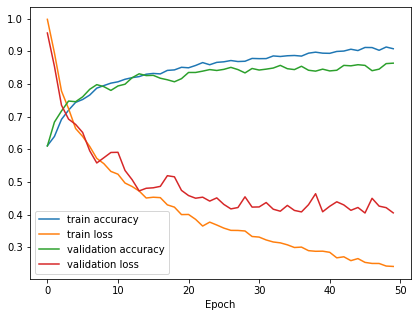

In [45]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')

# plt.subplot(1, 2, 2)

# plt.xlabel('Epoch')
# plt.legend(loc='lower left')

test_loss, test_acc = model.evaluate(test_img,  test_labels, verbose=0)

print(f"acc is {test_acc*100}%")

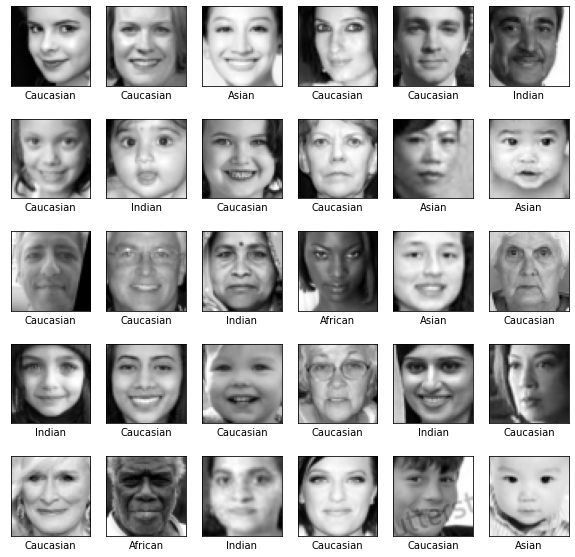

(1290,)
[0 0 2 0 0 3 0 3 0 0 2 2 0 0 3 1 2 0 3 0 0 0 3 0 0 1 3 0 0 2]


In [46]:
predicted_Labels = model.predict(X_TEST)

showImages(X_TEST, predicted_Labels, offset=10)

y_pred = np.array([np.argmax(label) for label in predicted_Labels])
print(y_pred.shape)
print(y_pred[10:40])

(1, 50, 50, 1)
Caucasian


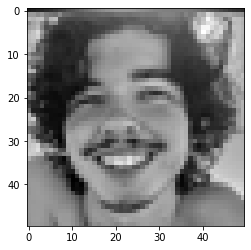

In [47]:
import PIL
an_image = PIL.Image.open("image.jpg").convert('L').resize((50,50))

image_array = np.asarray(an_image)

image_array = image_array/255
image_array = image_array.reshape(-1,50,50,1)
print(image_array.shape)

predicted = model.predict(image_array)
class_names = ['Caucasian', 'African', 'Asian', 'Indian']
plt.imshow(image_array[0], cmap="gray")
print(class_names[ int( np.argmax(predicted) ) ])